# Image Processing

## Requirements

* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* "pip" and  "PyMaxFlow"
* NumPy, SciPy, y Matplotlib.
* PyGame.
* OpenCV.

## Brief overview

* Image processing transformation and analysis
* Image filtering and Edges detector
* Segmentation algorithm and Hough transform

## Transformations

**Ejercicio 1.** Carga la imagen ``escilum.tif``. Calcula
y muestra su histograma, por ejemplo,  con la función ``hist()`` de
``matplotlib.pyplot``. A la vista del histograma, discute
qué problema tiene la imagen para analizar visualmente la
región inferior izquierda.

In [1]:
#librerias utilizadas
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pygame as pg
import maxflow as mf

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


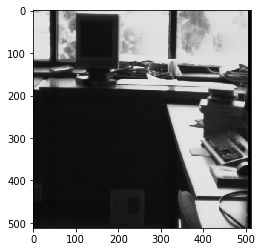

In [2]:
#lectura de imagen
im= cv2.imread('./imagenes/escilum.tif')
plt.imshow(im)

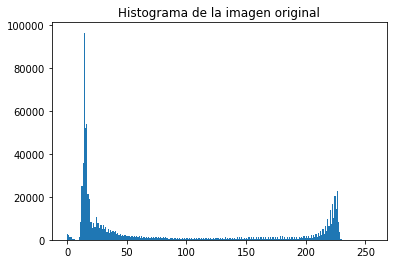

In [3]:
plt.hist(im.ravel(),255,[0,255])
plt.title('Histograma de la imagen original')
plt.show()

__Problema:__

Viendo el histograma de esta imagen, como se vio en clase, existe una concentración de píxeles en los extremos. 
Es decir, existe una acumulación de píxeles en zonas de baja y alta intensidad, dejando el resto de la region del histograma con muy poca cantidad de píxeles.
De esta manera es dificil obtener toda la información que presenta la imagen.





***



**Ejercicio 2.** Escribe una función ``eq_hist(histograma)``
que calcule la función de transformación puntual que ecualiza el histograma.
Aplica la función de transformación a la imagen anterior.
Calcula y muestra nuevamente el histograma y la imagen
resultantes, así como la función de transformación.

Discute los resultados obtenidos. ¿Cuál sería el resultado si volviésemos a ecualizar la imagen resultante?

En este ejercicio tienes que implementar la función que ecualiza el histograma. No puedes usar funciones que lo hagan por ti.

In [4]:
histograma = np.histogram(im.flatten(),255,[0,255])

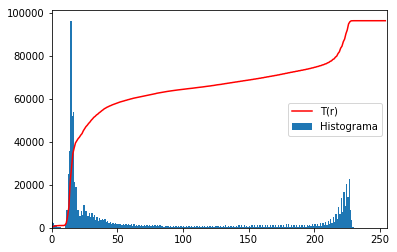

In [5]:
#función de ecualización con NumPy
def eq_hist(histograma):
    #operando vectorialmente:
    hist = histograma[0]
    bins = histograma[1]
    #acumulada:
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    
    plt.plot(cdf_normalized, color = 'r')
    plt.xlim([0,255])
    plt.legend(('T(r)','Histograma'), loc = 'right')
    return plt.show()

plt.hist(im.flatten(),255,[0,255])
eq_hist(histograma)
    

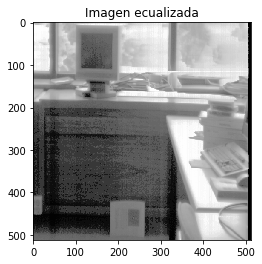

In [6]:
hist = histograma[0]
bins = histograma[1]
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

im2 = cdf[im]
plt.title('Imagen ecualizada')
plt.imshow(im2)



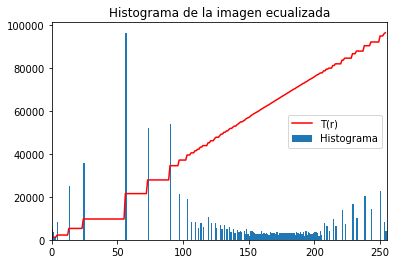

In [7]:
histograma2 = np.histogram(im2.flatten(),255,[0,255])
plt.hist(im2.flatten(),255,[0,255])
plt.title('Histograma de la imagen ecualizada')
eq_hist(histograma2)

**Resultados**

El histograma de la imagen ecualizada muestra un rango dinámico más equilibrado en el que se han repartido los píxeles, obteniendo una imagen con menor contraste. Como se analizó en clase, al aplicar una nueva ecualización, no cambiaría nada puesto que se ha encontrado la función que maximiza la distribución de los píxeles.
***

#  Filtering

Para realizar las convoluciones utiliza la función ``convolve`` o ``convolve1d`` de ``scipy.ndimage.filters``,
segun corresponda.


Carga y muestra las imágenes ``escgaus.bmp`` y ``escimp5.bmp`` que están contaminadas respectivamente
con ruido de tipo gaussiano e impulsional. En los siguientes ejercicios también puedes utilizar otras imágenes que te parezcan interesantes.

Text(0.5,1,'Ruido impulsional')

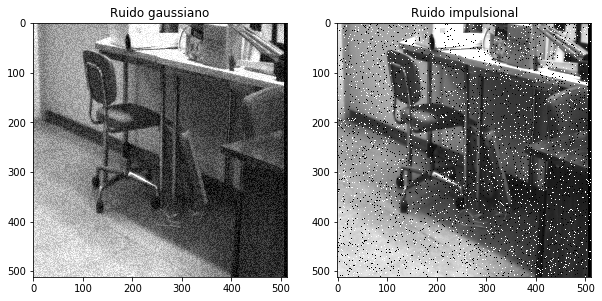

In [8]:
#lectura y display de imágenes
escgaus= cv2.imread('./imagenes/escgaus.bmp')
escimp5= cv2.imread('./imagenes/escimp5.bmp')

f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(escgaus)
axarr[0].set_title('Ruido gaussiano')
axarr[1].imshow(escimp5)
axarr[1].set_title('Ruido impulsional')



**Ejercicio 3.** Escribe una función ``masc_gaus(sigma, n)``
que construya una máscara de una dimensión de un filtro
gaussiano de tamaño *n* y varianza σ . Filtra las imágenes
anteriores con filtros bidimensionales de diferentes tamaños
de *n* , y/o σ.

En este ejercicio tienes que implementar la función que construye la máscara. No puedes usar funciones que construyan la máscara o realicen el filtrado automáticamente.

Muestra y discute los resultados. Pinta alguna de las máscaras construidas.



In [9]:
def masc_gaus(sigma, n):
    H= np.zeros((n,n))
    y,x = np.ogrid[0:n,0:n]
    H= np.e**(-0.5*((x-((n-1)/2))/sigma)**2)
    termino2=0
    for k in range(0,n):
        termino2+=np.e**(-0.5*(((k-((n-1)/2))/sigma)**2))                    
    Masc=np.asarray([i/termino2 for i in H])                       
    return Masc

Aprovechando que $h_{g}$$^{n x n}$ = $h_{gx}$$^{n}$ * $h_{gy}$$^{n}$:


In [192]:
def masc_gaus2d(sigma,n):
    Mascx=masc_gaus(sigma,n)
    Mascy=masc_gaus(sigma,n)
    #La convolusción equivale a:
    Masc=Mascx*(Mascy.transpose())
    return Masc

Otra manera de obtenerla:

In [11]:
def masc_gaus_v2(sigma, n):
    H= np.zeros((n,n))
    m,n = [(k-1.)/2. for k in (n,n)]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    H=1./(2*np.pi*(sigma**2))*np.e**(-(x**2+y**2)/(sigma**2))
    return H

Algunos ejemplos con diferentes $\sigma$ y tamaños (n x n):

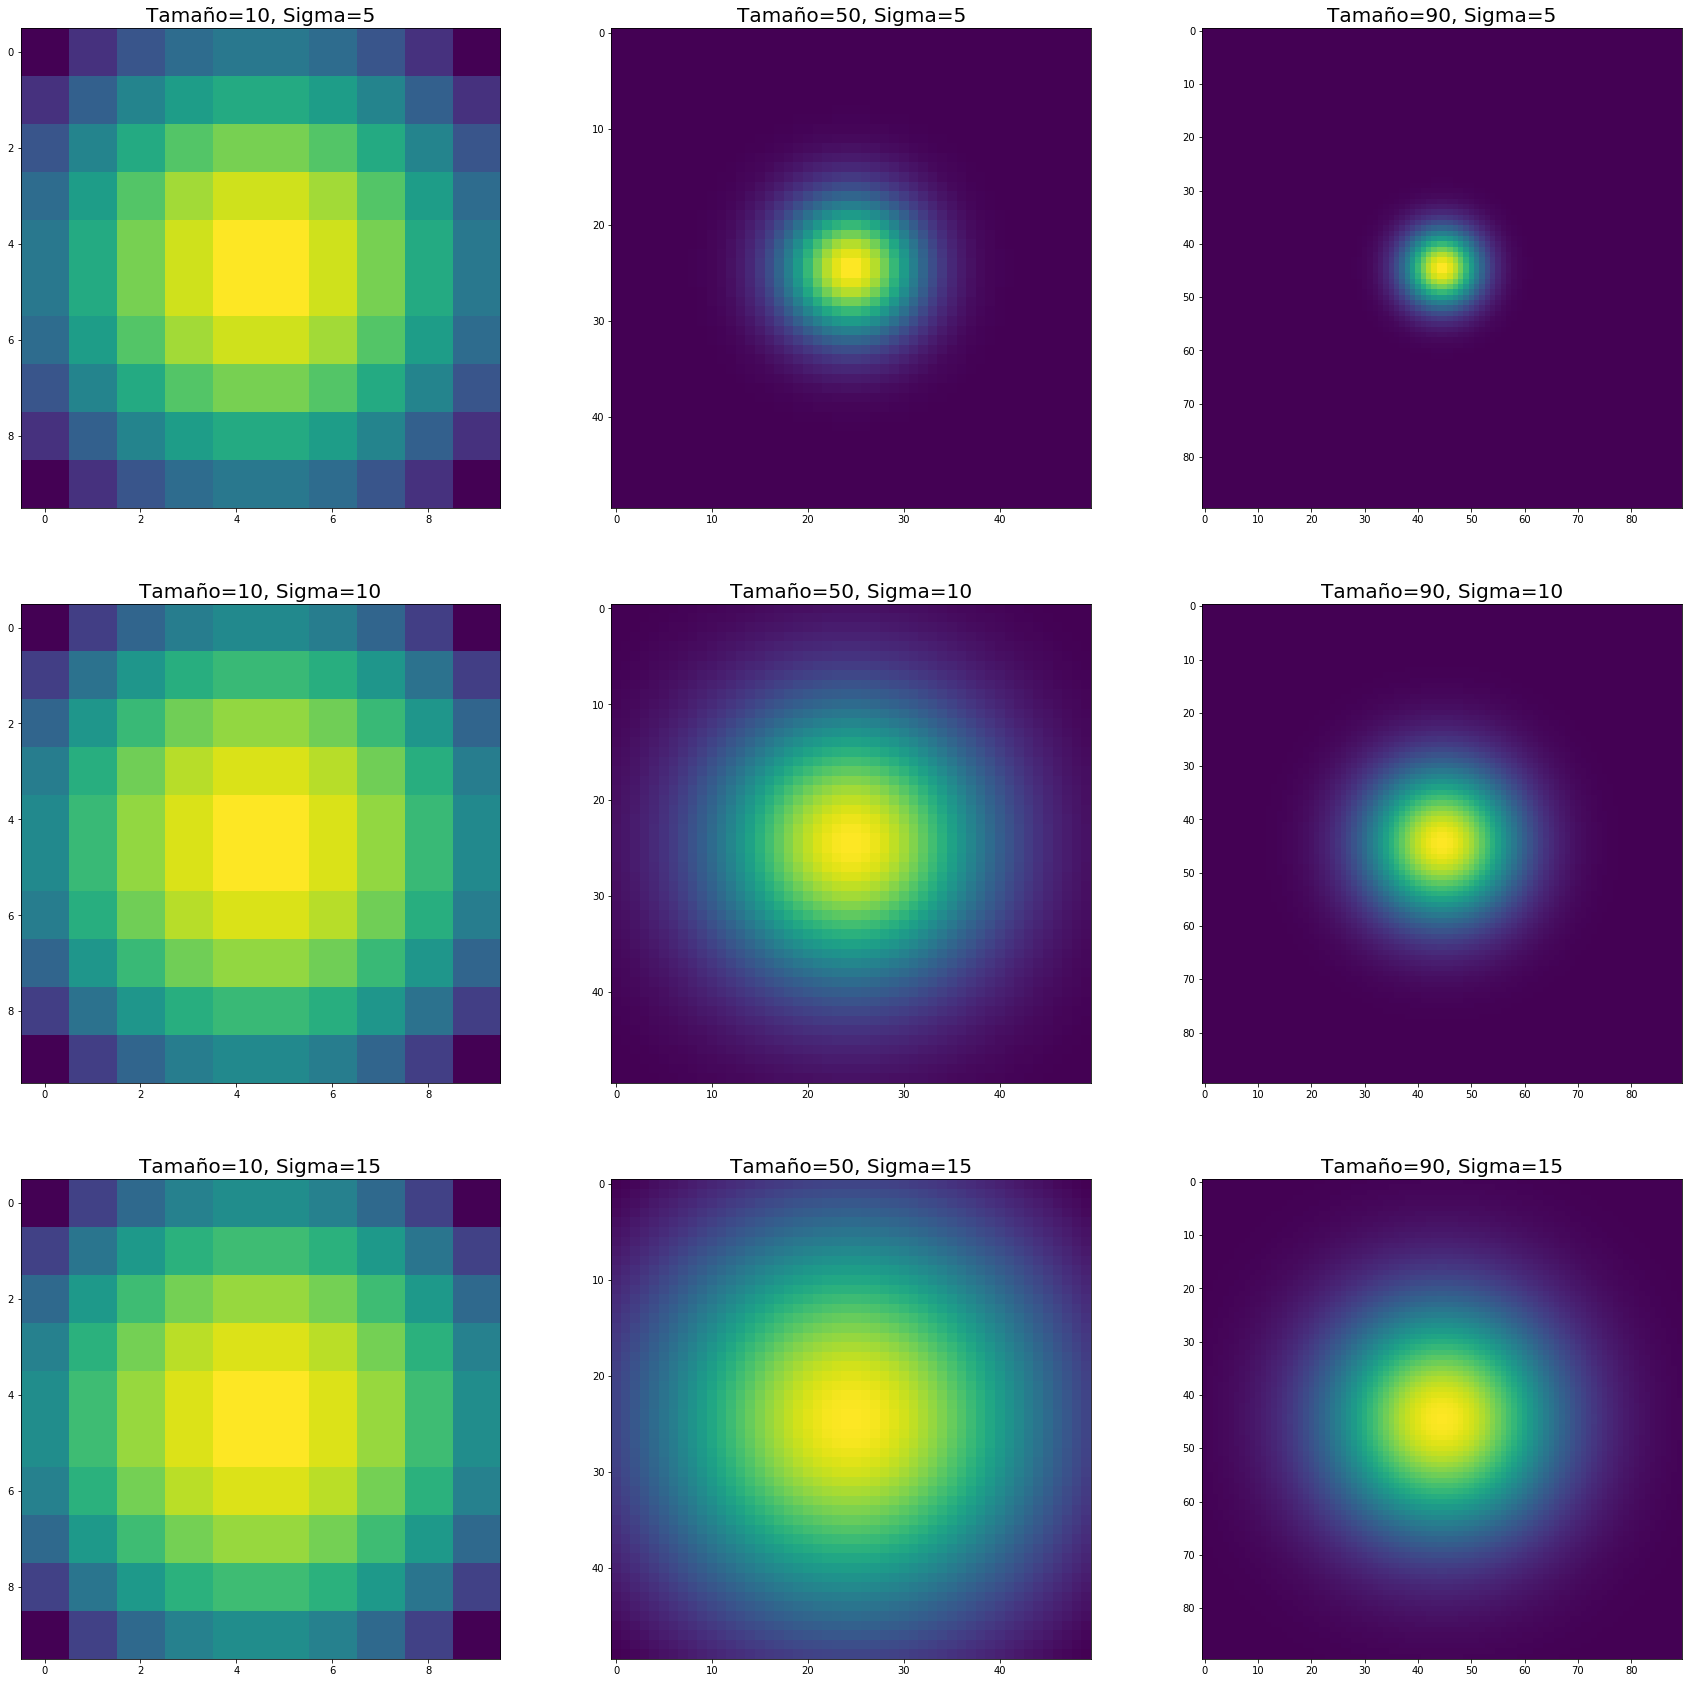

In [12]:
m=0
Kernels=[]
K=np.zeros((3, 3))

g, ax = plt.subplots(3,3,figsize=(30,30))

for i in range(5,20,5):
    n=0
    for j in range(10,120,40):
        H=masc_gaus2d(i,j)
        Kernels.append(H)
        ax[m,n].imshow(H)
        ax[m,n].set_title('Tamaño=%i, Sigma=%i' %(j, i),fontsize=20)        
        n+=1
    m+=1
plt.show()

Aplicandolos a la imagen 'escgaus.bmp', se obtiene estos resultados:

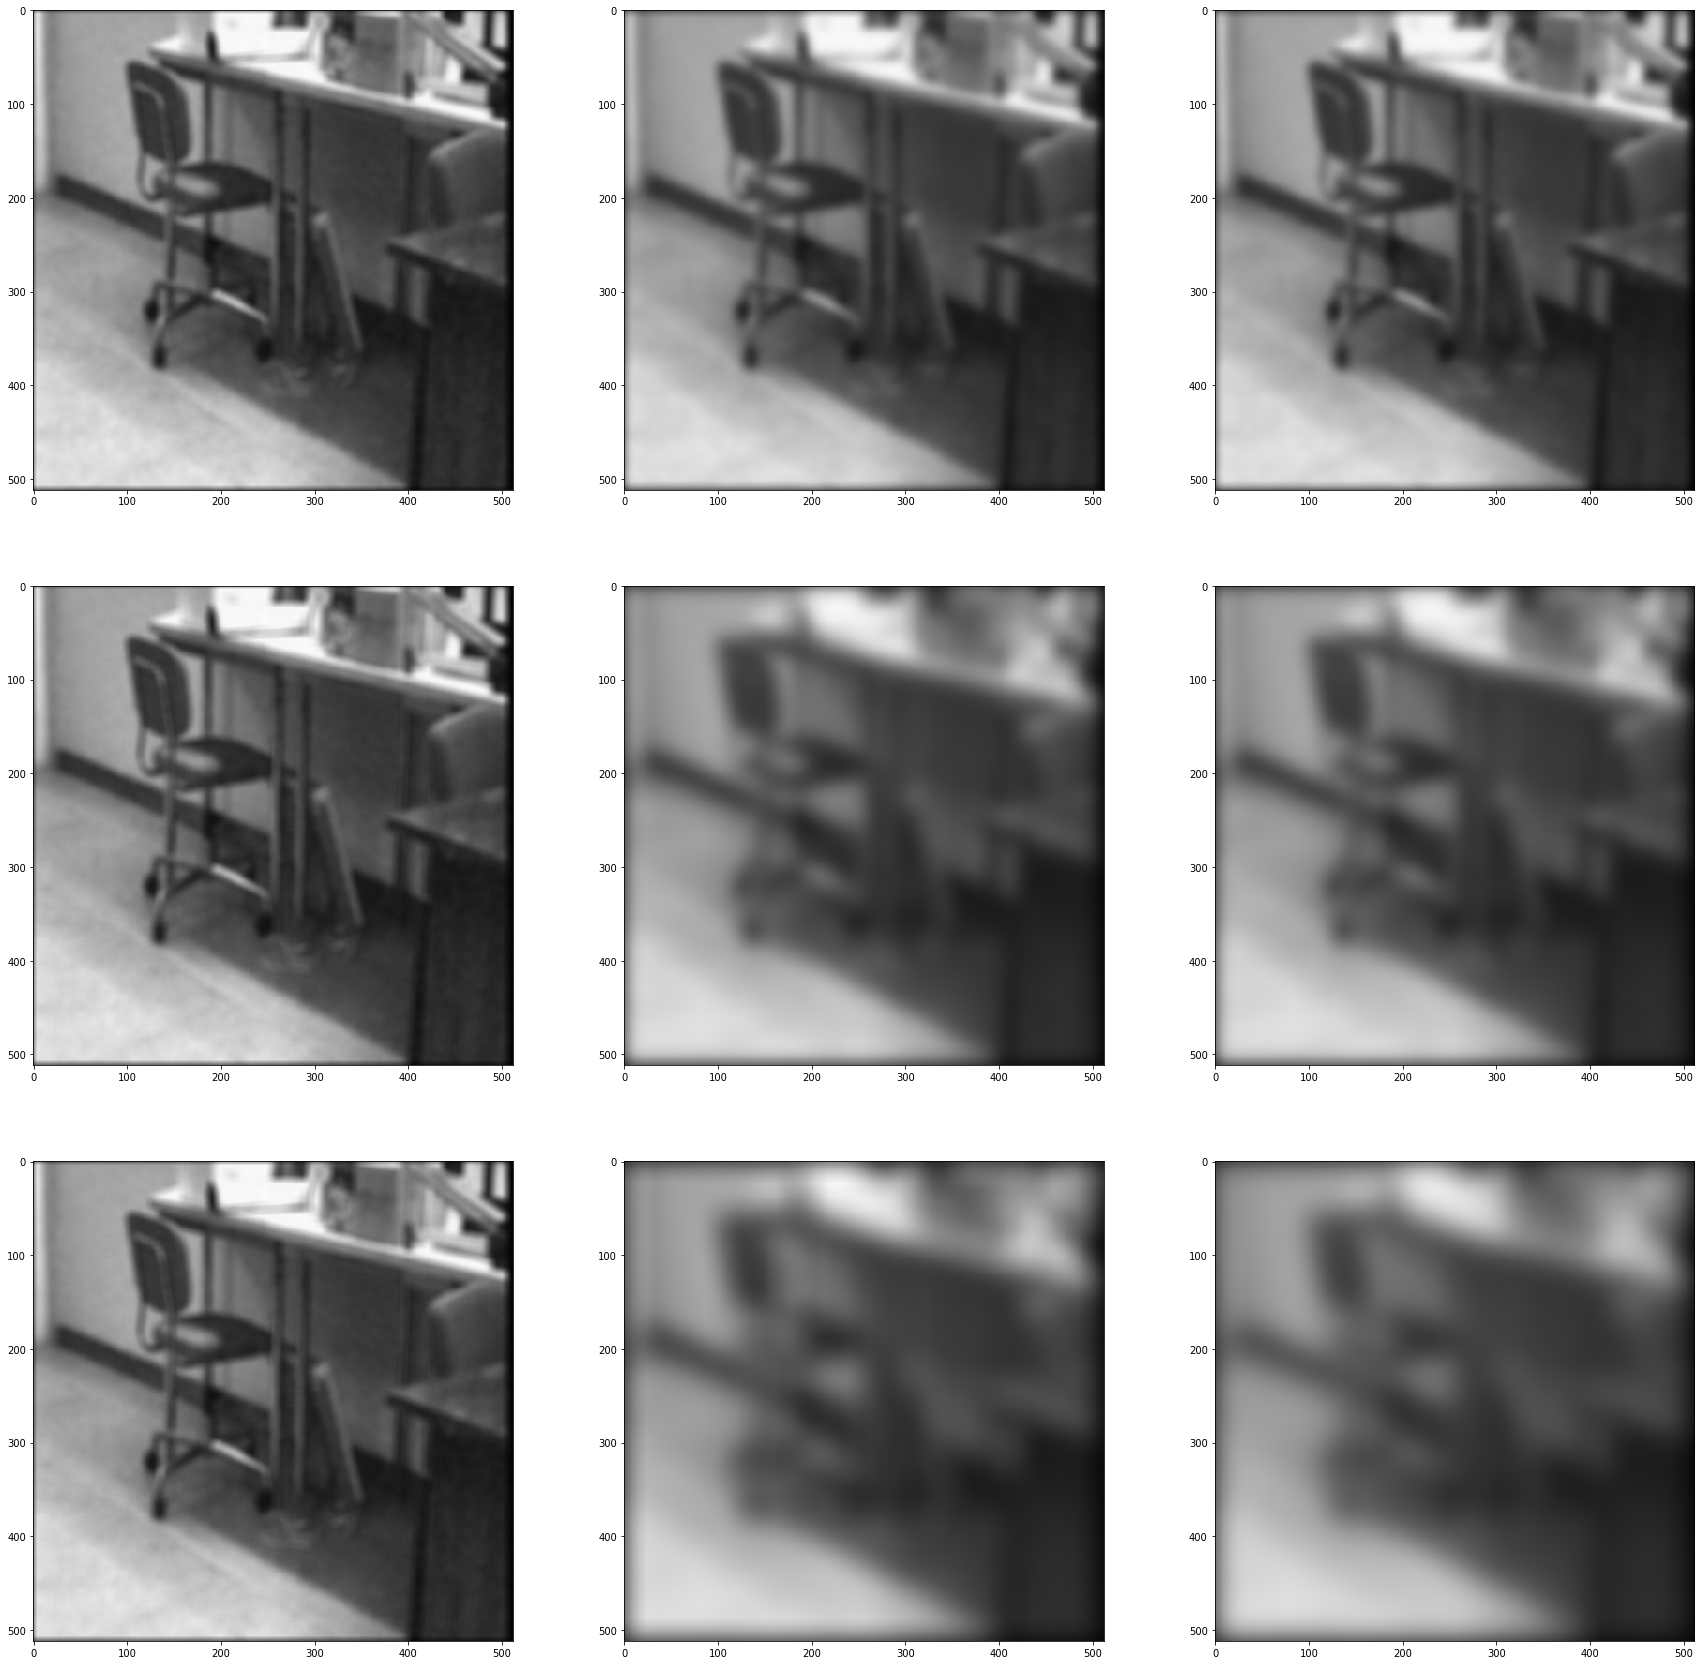

In [13]:
from scipy.ndimage import filters

f, ay = plt.subplots(3,3,figsize=(30,30))

for k in range(3):
    n=0
    for i in range(3*k,3*k+3):
        H=Kernels[i]
        Kernel = H[:,:,None]
        convolved=filters.convolve(escgaus, Kernel, mode='constant', cval=0.0)
        ay[k,n].imshow(convolved)
        n+=1        
plt.show()

Aplicando el filtro Gaussiano sobre una imagen con ruido de tipo impulsional, es de esperar que no funcione tan bien:

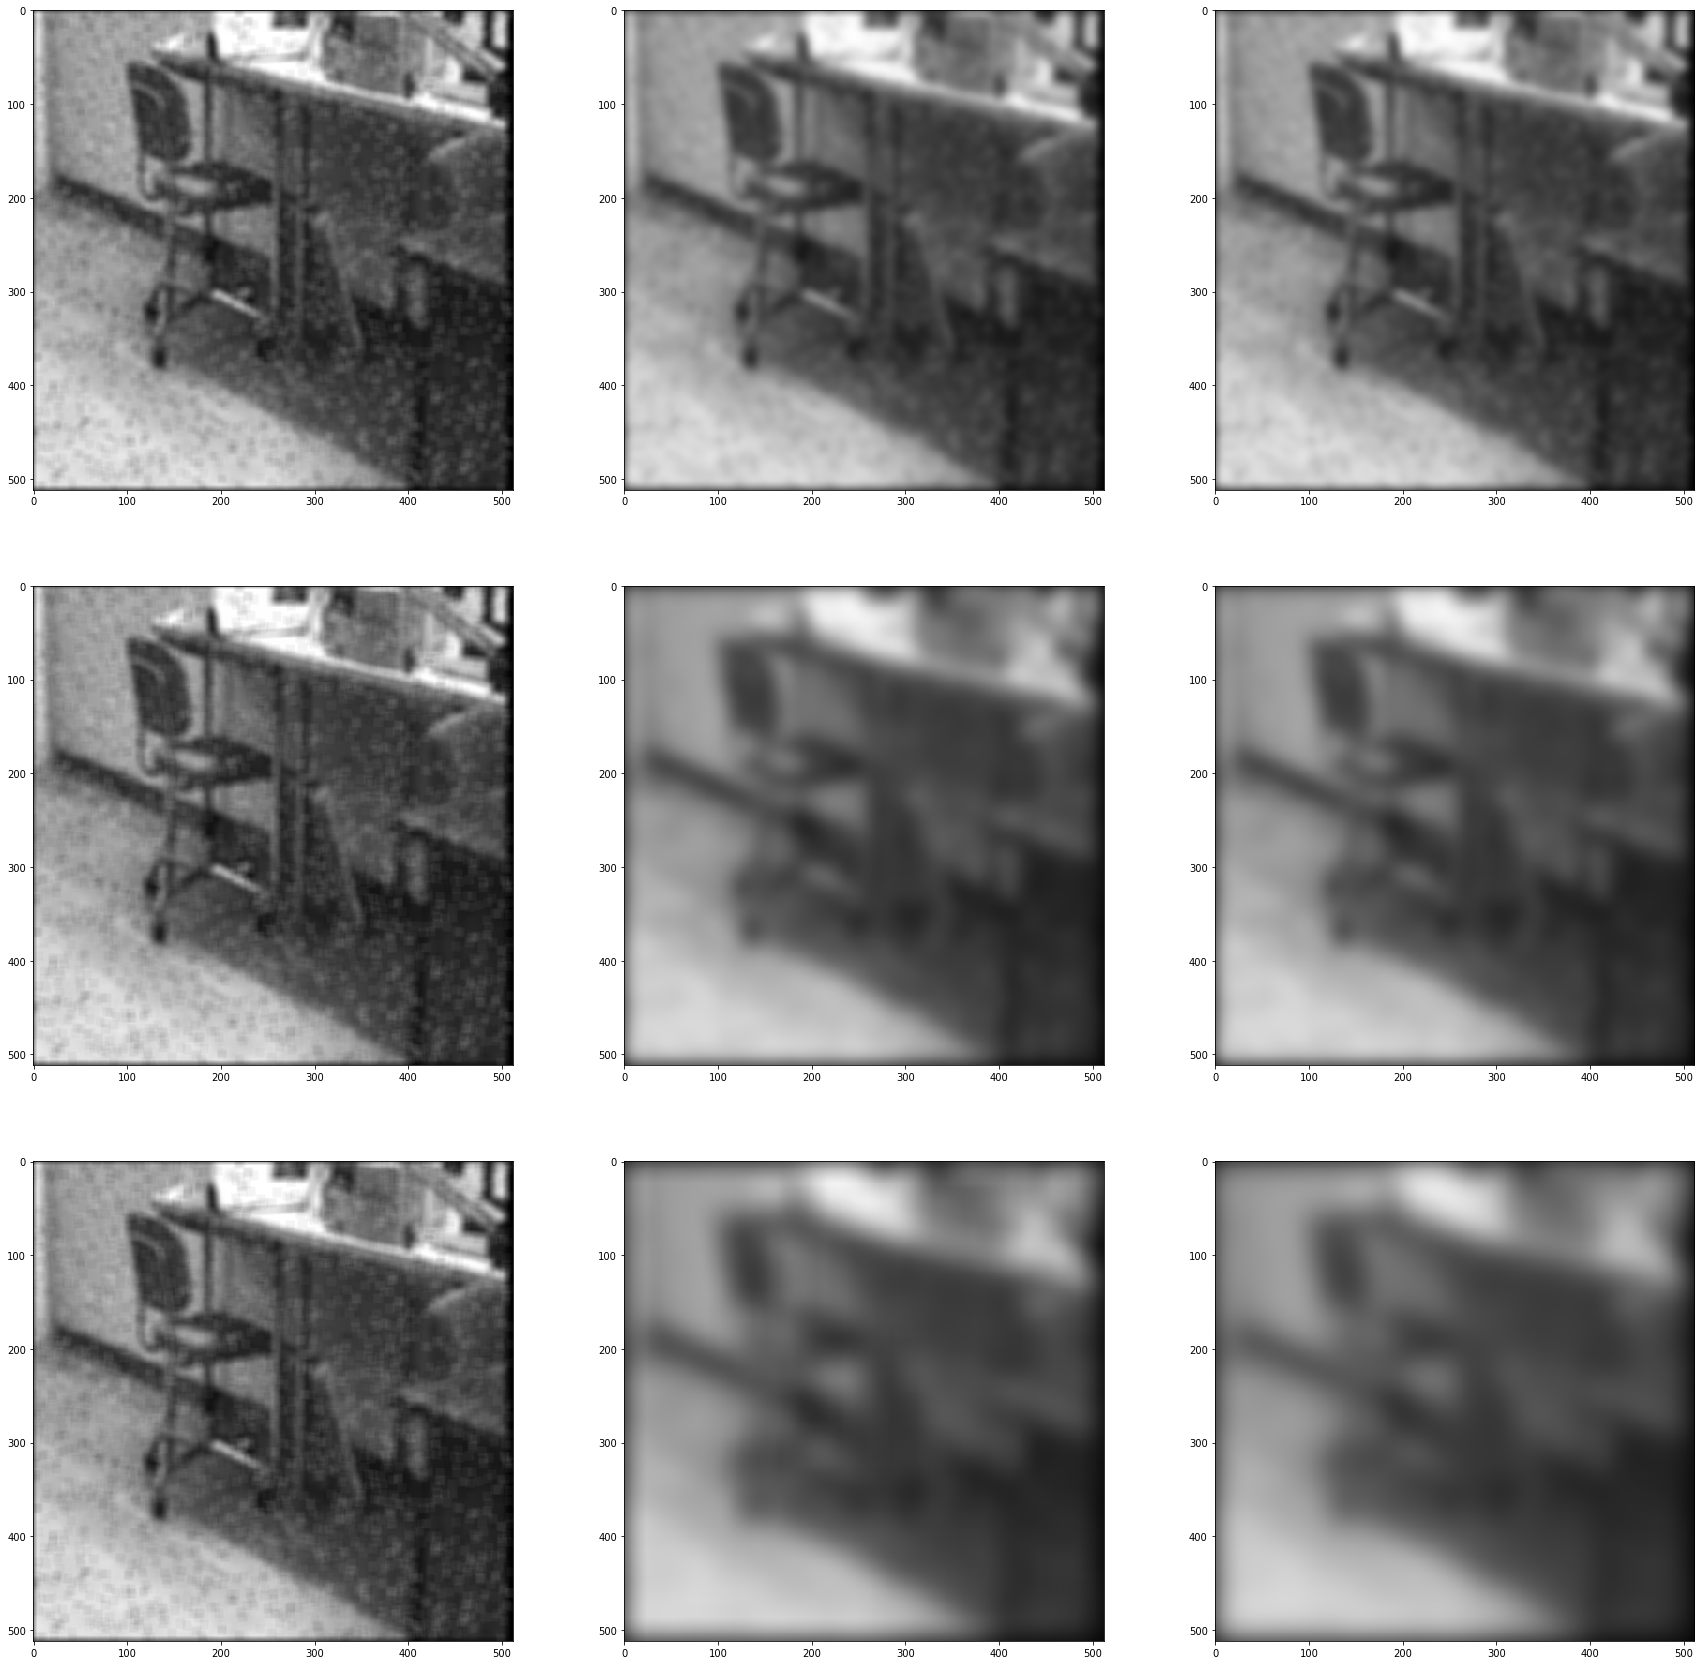

In [14]:
from scipy.ndimage import filters

p, az = plt.subplots(3,3,figsize=(30,30))

for k in range(3):
    n=0
    for i in range(3*k,3*k+3):
        H=Kernels[i]
        Kernel = H[:,:,None]
        convolved=filters.convolve(escimp5, Kernel, mode='constant', cval=0.0)
        az[k,n].imshow(convolved)
        n+=1        
plt.show()

Como era de esperar, el efecto de un filtro Gaussiano sobre una imagen con ruido de tipo impulsional, no es tan bueno. Para eliminar este tipo de ruido, sería más conveniente un filtro de tipo 'filtro de la mediana'.

Aplicando filtros de mayor tamaño, se obtiene un mayor suavizado. Por otro lado cuanto mayor es la desviación típica, existe menor distinción de bordes.


***

**Ejercicio 4.** Escribe una función ``masc_deriv_gaus(sigma, n)`` que construya una máscara de una dimensión de un
filtro derivada del gaussiano de tamaño *n* y varianza σ. Filtra la imagen ``corridor.jpg`` con filtros bidimensionales de derivada
del gaussiano para extraer los bordes de la imagen. Prueba con diferentes valores de *n* y/o σ.

Muestra y discute los resultados. Pinta alguna de las máscaras construidas.

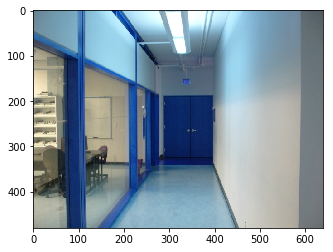

In [15]:
#lectura y display de imágenes
corridor= cv2.imread('./imagenes/corridor.jpg')
plt.imshow(corridor)


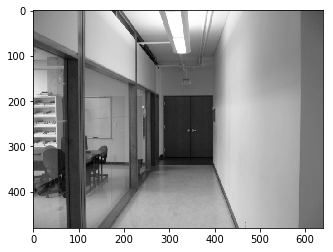

In [102]:
corridor_gray= cv2.imread('./imagenes/corridor.jpg',0)
plt.imshow(corridor_gray, cmap='gray')

Text(0.5,1,'Mascara y')

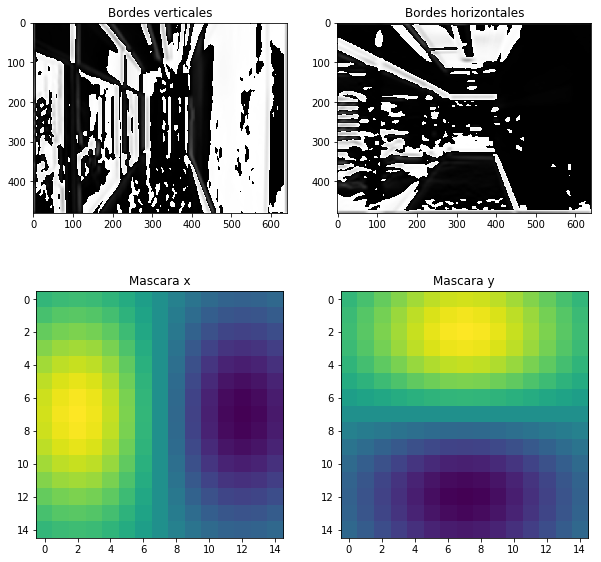

In [191]:
def masc_deriv_gaus(sigma, n):
    H= np.zeros((n,n))
    y,x = np.ogrid[0:n,0:n]
    H= np.asarray((-(x-((n-1)/2))/(sigma**2))*np.e**(-0.5*((x-((n-1)/2))/sigma)**2))                           
    return H

def masc_deriv_gaus2d(sigma, n):
    Hdx=masc_deriv_gaus(sigma,n)
    Hdy=masc_deriv_gaus(sigma,n)
    Hx=masc_gaus(sigma,n)
    Hy=masc_gaus(sigma,n)
    Dx=Hdx*Hy.transpose()
    Dy=Hdy.transpose()*Hx
    
    return Dx,Dy

#ejemplo
Kernelx,Kernely= masc_deriv_gaus2d(5,15)
convolvedx=filters.convolve(corridor_gray, Kernelx, mode='constant', cval=0.0)
convolvedy=filters.convolve(corridor_gray, Kernely, mode='constant', cval=0.0)

#plots de los resultados:
f, axarr = plt.subplots(2,2,figsize=(10,10))
axarr[0,0].imshow(convolvedx,cmap='gray')
axarr[0,0].set_title('Bordes verticales')
axarr[0,1].imshow(convolvedy,cmap='gray')
axarr[0,1].set_title('Bordes horizontales')
axarr[1,0].imshow(Kernelx)
axarr[1,0].set_title('Mascara x')
axarr[1,1].imshow(Kernely)
axarr[1,1].set_title('Mascara y')


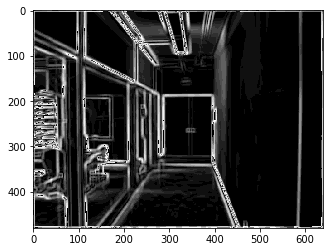

In [172]:
import scipy

Total=(np.square(convolvedx)+np.square(convolvedy))
a=(np.round(np.sqrt(Total))).astype(int)


plt.imshow(a,cmap='gray')


Se ha calculado de esta otra manera, para poder contrastar las diferencias:

Text(0.5,1,'Mascara y')

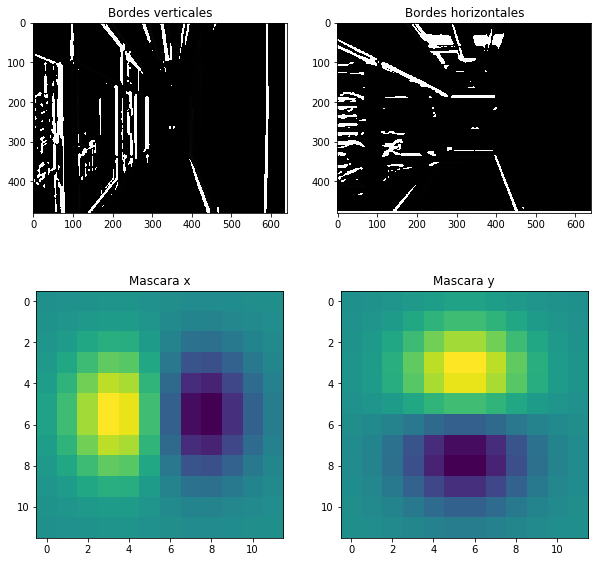

In [173]:
#Otra manera
def masc_deriv_gaus_v2(sigma, n):
    H= np.zeros((n,n))
    m,n = [(k-1.)/2. for k in (n,n)]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    Hx=1./(2*np.pi*(sigma**2))*(np.e**(-(x**2+y**2)/(sigma**2)))*(-2*x/(sigma**2))
    Hy=1./(2*np.pi*(sigma**2))*(np.e**(-(x**2+y**2)/(sigma**2)))*(-2*y/(sigma**2))
    return Hx, Hy

#ejemplo con tamaño=10 y sigma=5
Kernelx,Kernely= masc_deriv_gaus_v2(3,12)
convolvedx=filters.convolve(corridor_gray, Kernelx, mode='constant', cval=0.0)
convolvedy=filters.convolve(corridor_gray, Kernely, mode='constant', cval=0.0)

#plots de los resultados:
f, axarr = plt.subplots(2,2,figsize=(10,10))
axarr[0,0].imshow(convolvedx,cmap='gray')
axarr[0,0].set_title('Bordes verticales')
axarr[0,1].imshow(convolvedy,cmap='gray')
axarr[0,1].set_title('Bordes horizontales')
axarr[1,0].imshow(Kernelx)
axarr[1,0].set_title('Mascara x')
axarr[1,1].imshow(Kernely)
axarr[1,1].set_title('Mascara y')


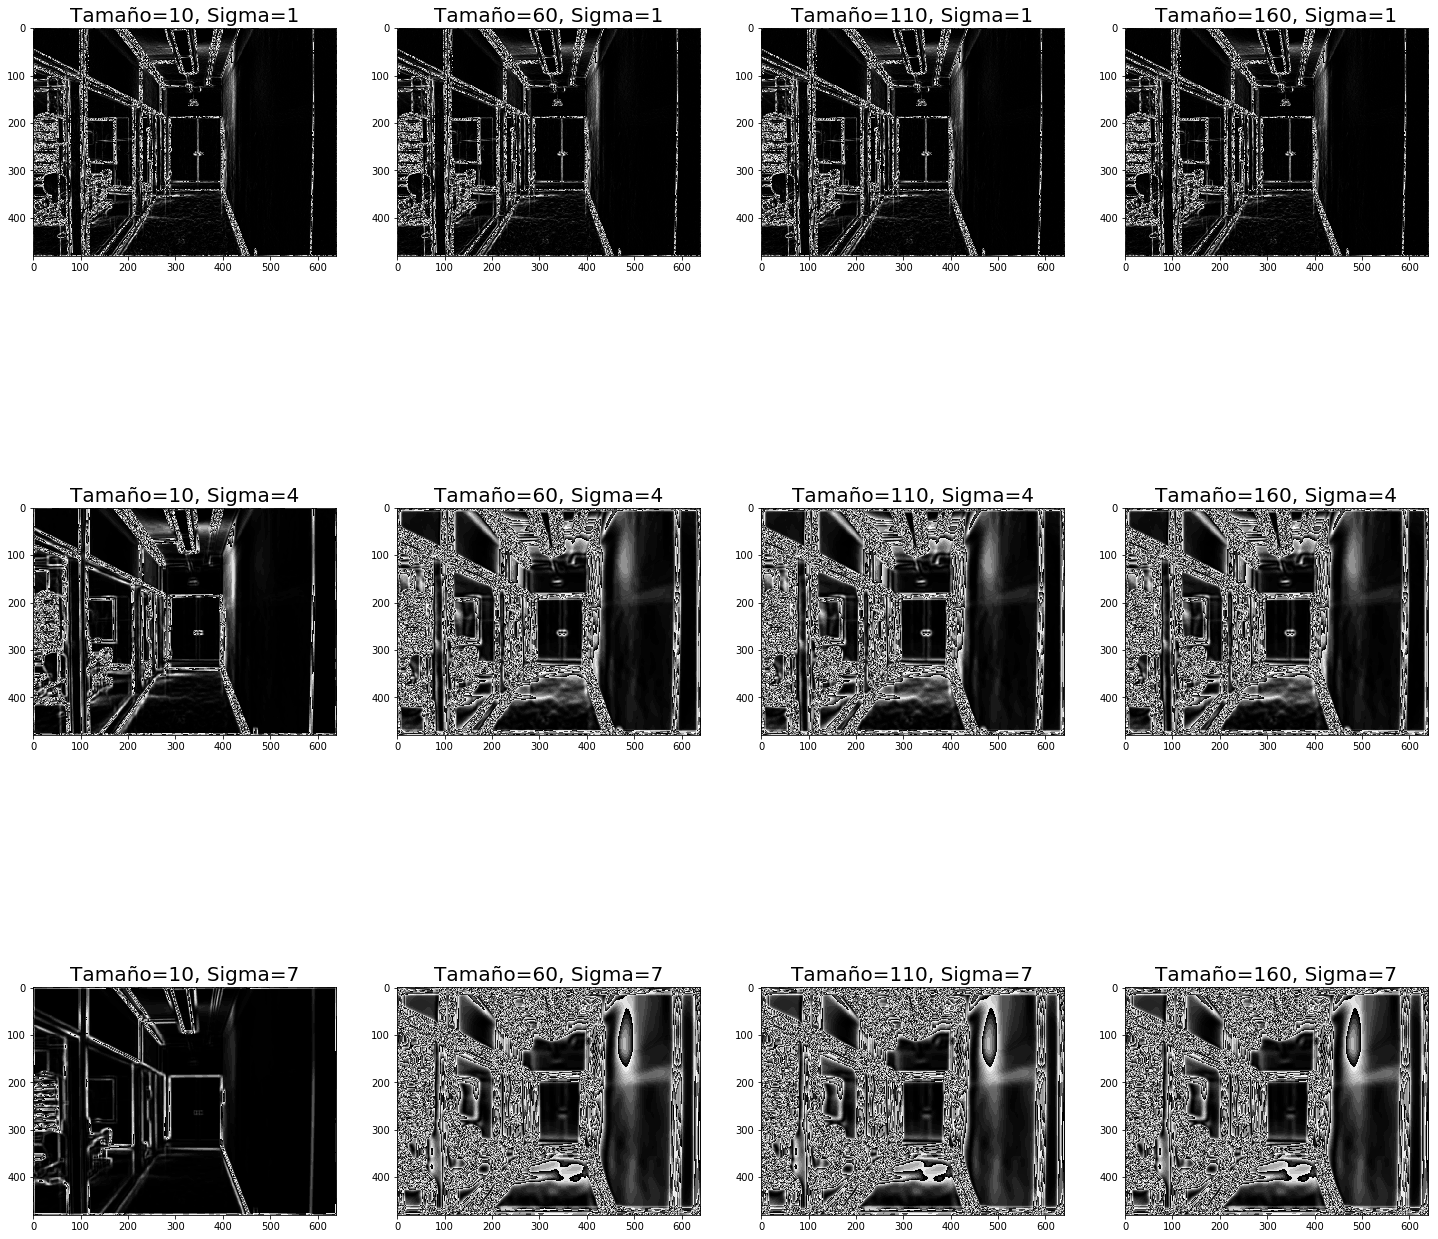

In [163]:
#plots de los resultados para varios tamaños,n y varias sigma.
f, ax = plt.subplots(3,4,figsize=(25,25))

for k in range(0,3):
    n=0
    for j in range(10,200,50):
        m=(1+3*k)
        Kernelx,Kernely= masc_deriv_gaus2d(m,j)
        convolvedx=filters.convolve(corridor_gray, Kernelx, mode='constant', cval=0.0)
        convolvedy=filters.convolve(corridor_gray, Kernely, mode='constant', cval=0.0)
        convolve_total=convolvedx*convolvedx+convolvedy*convolvedy
        ax[k,n].imshow(convolve_total,cmap="gray")
        ax[k,n].set_title('Tamaño=%i, Sigma=%i' %(j, m),fontsize=20)    
        n+=1

Indudablemente, en este caso conviene un $\sigma$ mayor, ya que no preserva los bordes y/o relieves innecesarios.

**Ejercicio 5.** Compara los tiempos de ejecución de las convoluciones anteriores cuando se realizan con ``convolve1d`` en vez de con ``convolve``.
Analiza los tiempos para diferentes valores de *n* y justifica los resultados.

In [95]:
# Posible ejemplo de código
import time

for n in range(10,200,30):
    Kernelx,Kernely= masc_deriv_gaus2d(1,n)
    start_time = time.process_time()
    # ejecuta convoluciones ....
    convolvedx=filters.convolve(corridor_gray, Kernelx, mode='constant', cval=0.0)
    convolvedy=filters.convolve(corridor_gray, Kernely, mode='constant', cval=0.0)
    convolve_total=(np.round(np.sqrt(np.square(convolvedx)+np.square(convolvedy)))).astype(int)

    print("Para n=",n," :",time.process_time() - start_time, "seconds")

Para n= 10  : 0.34375 seconds
Para n= 40  : 0.75 seconds
Para n= 70  : 1.0625 seconds
Para n= 100  : 1.859375 seconds
Para n= 130  : 3.921875 seconds
Para n= 160  : 7.953125 seconds
Para n= 190  : 15.25 seconds


In [98]:
# Posible ejemplo de código
import time

for n in range(10,200,30):
    Kernelx= masc_deriv_gaus(1,n)
    Kernely= masc_deriv_gaus(1,n)
    start_time = time.process_time()
    # ejecuta convoluciones ....
    convolvedx=filters.convolve1d(corridor_gray, Kernelx[0], mode='constant', cval=0.0,axis=0)
    convolvedy=filters.convolve1d(corridor_gray, Kernely.ravel(), mode='constant', cval=0.0,axis=1)
    convolve_total=(np.round(np.sqrt(np.square(convolvedx)+np.square(convolvedy)))).astype(int)
    print("Para n=",n," :",time.process_time() - start_time, "seconds")

Para n= 10  : 0.140625 seconds
Para n= 40  : 0.15625 seconds
Para n= 70  : 0.21875 seconds
Para n= 100  : 0.53125 seconds
Para n= 130  : 0.578125 seconds
Para n= 160  : 0.65625 seconds
Para n= 190  : 0.703125 seconds


Al realizar las convoluciones en 1D se reduce sustancialmente el coste computacional, como era de esperar debido al menor número de operaciones que conlleva reducir una dimensión. 

***

**Ejercicio 6.** Aplica el filtro de la mediana a las imágenes
``escgaus.bmp`` y ``escimp5.bmp`` con diferentes valores de tamaño de la ventana. Muestra y discute los resultados. Compáralos con los obtenidos en el Ejercicio 3.

Para realizar este ejercicio puedes utilizar la función ``cv2.medianBlur()`` de OpenCV, ``scipy.ndimage.median_filter()`` de SciPy o hacer tu propia función. Para ello puedes escribir una función ``mediana(img, n)`` y aplicarla a la imagen con la función ``scipy.ndimage.filters()``.



In [86]:
from scipy import ndimage

def mediana(img,n):
    resultado = ndimage.median_filter(img, size=n)
    return resultado

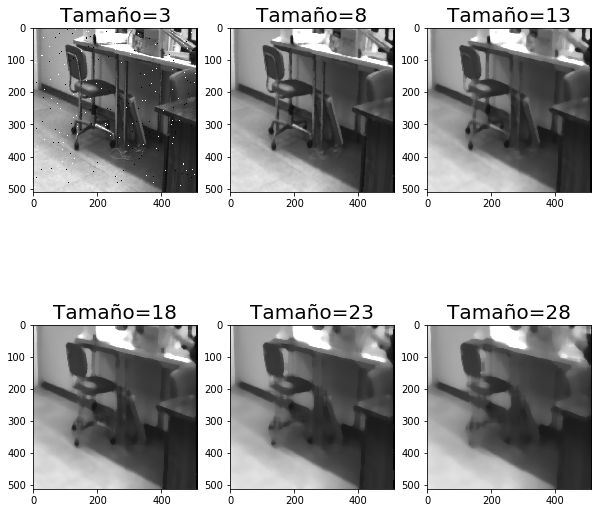

In [101]:
g, ax = plt.subplots(2,3,figsize=(10,10))

for k in range(2):
    n=0
    for i in range(15*k+3,15*k+14,5):
        r=mediana(escimp5,i)
        ax[k,n].imshow(r)
        ax[k,n].set_title('Tamaño=%i' % i,fontsize=20)
        n+=1

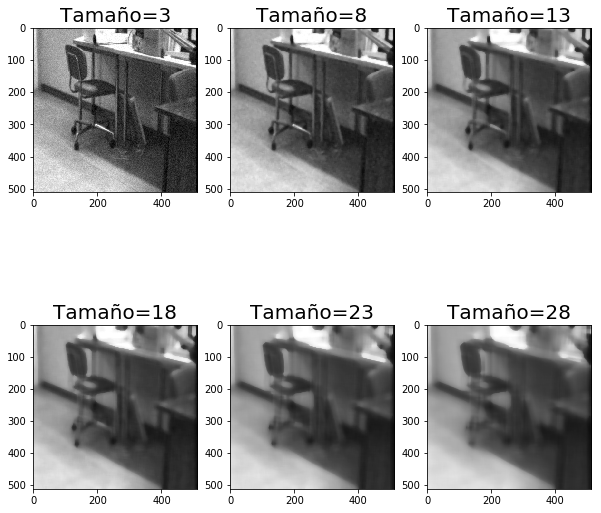

In [100]:
g, ax = plt.subplots(2,3,figsize=(10,10))

for k in range(2):
    n=0
    for i in range(15*k+3,15*k+14,5):
        r=mediana(escgaus,i)
        ax[k,n].imshow(r)
        ax[k,n].set_title('Tamaño=%i' % i,fontsize=20)
        n+=1

Como se mencionó anteriormente, este tipo de filtrado de la mediana, ofrece los mejores resultados para las imágenes con ruido de tipo impulsional. Se puede observar más arriba como un tamaño 8 en este caso, ofrece un resultado casi perfecto para esta imágen.

Sin embargo, en la imagen con ruido gaussiano, el ruido sigue presente para los kernels de menor tamaño. Con kernels de mayor tamaño se pierde mucha información sobre los bordes, en este caso.

**Ejercicio 7.** Utiliza la funcion ``cv2.bilateralFilter()`` de OpenCV para realizar el filtrado bilateral de una
imagen. Selecciona los parámetros adecuados y aplícalo a las imágenes ``escgaus.bmp`` y ``escimp5.bmp`` y otras que elijas tú.

Si llamamos $\sigma_r$ a la varianza de de la gaussiana que controla la ponderación debida a la diferencia entre los valores de los píxeles y $\sigma_s$ a la varianza de la gaussiana que controla la ponderación debida a la posición de los píxeles. Responde a la siguientes preguntas:
* ¿Cómo se comporta el filtro bilateral cuando la varianza $\sigma_r$ es muy alta? ¿En este caso qué ocurre si $\sigma_s$ es alta o baja?
* ¿Cómo se comporta si $\sigma_r$ es muy baja? ¿En este caso cómo se comporta el filtro dependiendo si $\sigma_s$ es alta o baja?

Muestra y discute los resultados para distintos valores de los parámetros y varias aplicaciones sucesivas del filtro. Compáralos con los obtenidos en los Ejercicios 3 y 6.

In [ ]:
escgaus_bilateral=cv2.bilateralFilter(escgaus,9,75,75)
escimp5_bilateral=cv2.bilateralFilter(escimp5,20,90,50)


f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(escgaus_bilateral)
axarr[0].set_title('Imagen con ruido gaussiano')
axarr[1].imshow(escimp5_bilateral)
axarr[1].set_title('Imagen con ruido impulsional')


**¿Cómo se comporta el filtro bilateral cuando la varianza $\sigma_r$ es muy alta? ¿En este caso qué ocurre si $\sigma_s$ es alta o baja?**

Una $\sigma_r$ muy alta, supondría que colores que más dispares en los píxeles vecinos seran mezclados, resultando en areas de color similar.

Teniendo además una $\sigma_s$ alta también, supondría que además píxeles que se encuentran alejados tendrían influencia entre sí, dado que los colores serán parecidos.
En caso de tener una $\sigma_s$ baja, sucederá lo contrario. Es decir, píxeles que solo los píxeles más cercanos se influenciaran entre sí.

**¿Cómo se comporta si $\sigma_r$ es muy baja? ¿En este caso cómo se comporta el filtro dependiendo si $\sigma_s$ es alta o baja?**

En caso de ser $\sigma_r$ muy baja, el filtro solo mezclará colores muy parecidos. 

Teneiendo una $\sigma_s$ alta, logrará que se suavizen los bordes más grandes además. Mientras una $\sigma_s$ baja, hará que además de tener un umbral muy bajo a la hora de mezclar colores, el efecto de suavizado de bordes será menor.




**Comparación entre los resultados de los ejercicios 3,6 y 7:**

En el *ejercicio 3*, se aplicaron filtros gaussianos de distintas dimensiones y distintos $\sigma^{'}$s a imágenes con ruidos, tanto de tipo gaussiano como de tipo impulsional. Los resultados mostraron que estos filtros actúan bien sobre las imágenes con ruido gaussiano, siendo coherente con la teoría.

En el *ejercicio 6*, se aplicaron filtros de la mediana de distintos tamaños sobre el mismo tipo imágenes. Se obtuvieron mejores resultados,cuando se aplicó el filtro sobre imágenes de tipo impulsional.

Finalmente en el *ejercicio 7*, se han aplicado filtros bilaterales sobre el mismo conjunto de imagenes, observando como este filtro es capaz de solventar los problemas tanto de uno como de otro, con diferente ajuste de parámetros.

***

## Hough Transformations

**Ejercicio 8.** Emplea la transformada Hough para encontrar segmentos rectilíneos en la imagen ``corridor.jpg``. Para extraer los bordes de la imagen utiliza las funciones escritas en los ejercicios 3 y 4. Utiliza la función ``cv2.HoughLinesP()`` de OpenCV.

Discute el funcionamiento para distintos valores de los parámetros de la función, así como de
los filtros utilizados para extraer los bordes de la imagen. Pinta los resultados sobre la imagen (mira como ejemplo, https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html).

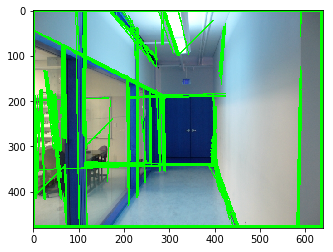

In [180]:
corridor= cv2.imread('./imagenes/corridor.jpg')
corridor_gray= cv2.imread('./imagenes/corridor.jpg',0)

Kernelx,Kernely= masc_deriv_gaus2d(17,10)
convolvedx=filters.convolve(corridor_gray, Kernelx, mode='constant', cval=0.0)
convolvedy=filters.convolve(corridor_gray, Kernely, mode='constant', cval=0.0)

Total=(np.square(convolvedx)+np.square(convolvedy))
a=(np.round(np.sqrt(Total))).astype(int)

lines = cv2.HoughLinesP(Total, 1, np.pi/180, 150, maxLineGap=30, minLineLength=10)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(corridor,(x1, y1),(x2, y2),(0,255,0),2)

plt.imshow(corridor,cmap='gray')

Antes de aplicar la transformada de Hough, se ha analizado la imagen en escala de grises. Para ello se ha utilizado, la función en ``imread`` en modo 0. 
Tras este paso se ha procedido a la extracción de bordes, utilizando el filtro derivado de la gaussiana. En él además se ha intentado mejorar el comportamiento, promediando en la dirección ortogonal a la que se ha derivado.

Finalmente, tras la extracción de bordes, se ha procedido a utilizar el algoritmo de ``HoughLinesP`` para determinar, mediante el sistema de votos, la posición de los segmentos rectilíneos en la imagen.


**Parámetros de la función ``HoughLinesP``:**

 - **dst**: Salida de la detección de bordes aplicada sobre la imagen.
 - **líneas**: vector que almacenará los parámetros (x_{start}, y_{start}, x_{end}, y_{end}) de las líneas detectadas
 - **rho**: La resolución del parámetro $\rho$ . Aquí se ha usado un píxel.
 - **theta**: La resolución del parámetro $\theta$ in radians. Aquí se ha usado un grado. ($\pi$/180)
 - **umbral**: El número mínimo de intersecciones/votos para “detectar” una línea
 - **LongitudMínima**: The minimum number of points that can form a line. Lines with less than this number of points are disregarded.
 - **EspacioMáximo**: El máximo espaciado entre dos puntos permitido, para que se considere quepertenecen a la misma línea.

***

## Segmentation

**Ejercicio 9.** Escribe una función que segmente el objeto central de una imagen a partir de una segmentación manual
inicial realizada por el usuario. Puedes utilizar el código proporcionado en el archivo segm.py. En la optimización
1. toma como afinidad entre una pareja de píxeles la
diferencia en sus valores de color y;
2. sólo establece los términos unitarios de los píxeles
marcados por el usuario.

Aplícalo, al menos, a las imágenes ``persona.png`` y ``horse.jpg``. Muestra y discute los resultados.

**Ejercicio 10.** Mejora el algoritmo anterior. Puedes utilizar algunas de las que te sugiero a continuación u otras que creas más convenientes:
* Refina la segmentación iterativamente.
* Mejora la función de afinidad entre píxeles.
* Mejora los términos unitarios

mejora los resultados de algunas de las imágenes anteriores. Muestra y discute los resultados.